In [5]:
Title = "Daily Dozen: personal diet diary"

In [6]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [7]:
#get the soup from the website
url = requests.get("https://nutritionfacts.org/daily-dozen/")
soup = BeautifulSoup(url.content, "html.parser")

In [8]:
#find the needed data in the soup and make lists
dd_grid = soup.find_all(attrs={"class":"daily-dozen-grid mt-3"})
dd = [foodgroup.text.strip() for entry in dd_grid for foodgroup in entry.find_all("h3")]
servings_and_examples = [serving.text.strip() for entry in dd_grid for serving in entry.find_all("p")]
examples = servings_and_examples[1::2]
servings = servings_and_examples[::2]

In [9]:
#make a dataframe out of the individual lists
df_dd = pd.DataFrame({
   "food_group": dd,
    "servings": servings, 
    "examples": examples})

df_dd['servings'] = df_dd['servings'].str.extract('(\d+)').astype(float)

In [10]:
df_dd["examples"] = df_dd["examples"].astype("string")
print(df_dd.dtypes)

food_group            object
servings             float64
examples      string[python]
dtype: object


In [11]:
#convert the 60 oz of drinks to five servings (five glasses - mugs of water, tea etc)
df_dd.loc[df_dd['food_group'] == "Beverages", 'servings'] = 5
#drop the exercise column, since it is not a foodgroup
df_dd = df_dd.drop(index=11)
print(df_dd)

                food_group  servings                                examples
0                    Beans       3.0     e.g. ½ c. cooked beans, ¼ c. hummus
1                  Berries       1.0   e.g. ½ c. fresh or frozen, ¼ c. dried
2             Other Fruits       3.0   e.g. 1 medium fruit, ¼ c. dried fruit
3   Cruciferous Vegetables       1.0   e.g. ½ c. chopped, 1 tbsp horseradish
4                   Greens       2.0              e.g. 1 c. raw, ½ c. cooked
5         Other Vegetables       2.0           e.g. ½ c. nonleafy vegetables
6                 Flaxseed       1.0                      e.g. 1 tbsp ground
7           Nuts and Seeds       1.0       e.g. ¼ c. nuts, 2 tbsp nut butter
8         Herbs and Spices       1.0                     e.g. ¼ tsp turmeric
9             Whole Grains       3.0  e.g. ½ c. hot cereal, 1 slice of bread
10               Beverages       5.0  e.g. Water, green tea,
			hibiscus tea


In [12]:
#change the foodgroups to be in line with the data later on
df_dd.at[6, 'food_group'] = 'Flaxseeds'
df_dd.at[7, 'food_group'] = 'Nuts'
df_dd.at[8, 'food_group'] = 'Spices'

In [13]:
print(df_dd)

                food_group  servings                                examples
0                    Beans       3.0     e.g. ½ c. cooked beans, ¼ c. hummus
1                  Berries       1.0   e.g. ½ c. fresh or frozen, ¼ c. dried
2             Other Fruits       3.0   e.g. 1 medium fruit, ¼ c. dried fruit
3   Cruciferous Vegetables       1.0   e.g. ½ c. chopped, 1 tbsp horseradish
4                   Greens       2.0              e.g. 1 c. raw, ½ c. cooked
5         Other Vegetables       2.0           e.g. ½ c. nonleafy vegetables
6                Flaxseeds       1.0                      e.g. 1 tbsp ground
7                     Nuts       1.0       e.g. ¼ c. nuts, 2 tbsp nut butter
8                   Spices       1.0                     e.g. ¼ tsp turmeric
9             Whole Grains       3.0  e.g. ½ c. hot cereal, 1 slice of bread
10               Beverages       5.0  e.g. Water, green tea,
			hibiscus tea


In [14]:
import json

In [15]:
json_file_path = '/Users/lottedieleman/Downloads/dailydozen_backup-1.json'

# Read the JSON file into a DataFrame
dd_data = pd.read_json(json_file_path, lines=True)
dd_data = dd_data.drop("tweaks", axis=1)
dd_data = dd_data.drop("eveningWeight", axis=1)
dd_data = dd_data.drop("morningWeight", axis=1)

# Display the DataFrame
print(dd_data.head())

       Date                                         dailyDozen
0  20240102  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
1  20240103  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
2  20240104  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
3  20240105  {'Spices': 1, 'Whole Grains': 3, 'Other Fruits...
4  20240106  {'Spices': 1, 'Whole Grains': 2, 'Other Fruits...


In [16]:
#adjust the dataframe
def json_to_dataframe(df, keys): 
    new_df = pd.json_normalize(df['dailyDozen'])
    new_df[keys] = new_df[keys]

new_keys = ["Spices", "Whole Grains", "Other Fruits", "Nuts", "Beans", "Cruciferous Vegetables", "Flaxseeds", "Other Vegetables", "Beverages", "Berries", "Exercise", "Greens"]   

for key in new_keys:
    dd_data[key] = pd.json_normalize(dd_data['dailyDozen'])[key]
        
dd_data = dd_data.drop(columns='dailyDozen')
print(dd_data.head())

       Date  Spices  Whole Grains  Other Fruits  Nuts  Beans  \
0  20240102       1             1             1     1      1   
1  20240103       1             1             2     1      1   
2  20240104       1             1             0     1      3   
3  20240105       1             3             0     1      3   
4  20240106       1             2             1     1      3   

   Cruciferous Vegetables  Flaxseeds  Other Vegetables  Beverages  Berries  \
0                       0          0                 2          5        1   
1                       1          0                 2          5        1   
2                       1          0                 2          4        1   
3                       1          0                 2          4        1   
4                       0          1                 2          5        1   

   Exercise  Greens  
0         0       0  
1         1       1  
2         0       0  
3         0       0  
4         1       0  


In [17]:
#check and change data types for datetime
from datetime import datetime

#print(dd_data.isnull().sum())
#print(dd_data.describe())

dd_data["Date"] = pd.to_datetime(dd_data["Date"].astype(str), format='%Y%m%d')
print(dd_data.head())

        Date  Spices  Whole Grains  Other Fruits  Nuts  Beans  \
0 2024-01-02       1             1             1     1      1   
1 2024-01-03       1             1             2     1      1   
2 2024-01-04       1             1             0     1      3   
3 2024-01-05       1             3             0     1      3   
4 2024-01-06       1             2             1     1      3   

   Cruciferous Vegetables  Flaxseeds  Other Vegetables  Beverages  Berries  \
0                       0          0                 2          5        1   
1                       1          0                 2          5        1   
2                       1          0                 2          4        1   
3                       1          0                 2          4        1   
4                       0          1                 2          5        1   

   Exercise  Greens  
0         0       0  
1         1       1  
2         0       0  
3         0       0  
4         1       0  


In [18]:
#drop the column Exercise, since it is not an actual foodgroup
#dd_data = dd_data.drop(columns=['Exercise'])

In [19]:
# on average: how much of the daily servings do I reach a day, per foodgroup, in the whole timeframe of recorded data? 

def percentage_reached(df_eaten):
    avg = []
    fg = []
    df_eaten = df_eaten.drop(columns=["Date"])
    for col in df_eaten:
        avg.append(dd_data[col].mean())
        fg.append(col)
    
    df_eaten_new = pd.DataFrame({
        "food_group" : fg, 
        "avg_eaten" : avg})
    
    df_all_info = pd.merge(df_eaten_new, df_dd, on='food_group')
    
    df_all_info["percentage"] = df_all_info["avg_eaten"] / df_all_info["servings"] * 100
    
    return df_all_info.sort_values(by='percentage')

In [54]:
dd_data.head()

,Date,Spices,Whole Grains,Other Fruits,Nuts,Beans,Cruciferous Vegetables,Flaxseeds,Other Vegetables,Beverages,Berries,Exercise,Greens,day_of_week
0,2024-01-02,1,1,1,1,1,0,0,2,5,1,0,0,Tuesday
1,2024-01-03,1,1,2,1,1,1,0,2,5,1,1,1,Wednesday
2,2024-01-04,1,1,0,1,3,1,0,2,4,1,0,0,Thursday
3,2024-01-05,1,3,0,1,3,1,0,2,4,1,0,0,Friday
4,2024-01-06,1,2,1,1,3,0,1,2,5,1,1,0,Saturday


In [61]:
df_dd.head()

,food_group,servings,examples
0,Beans,3.0,"e.g. ½ c. cooked beans, ¼ c. hummus"
1,Berries,1.0,"e.g. ½ c. fresh or frozen, ¼ c. dried"
2,Other Fruits,3.0,"e.g. 1 medium fruit, ¼ c. dried fruit"
3,Cruciferous Vegetables,1.0,"e.g. ½ c. chopped, 1 tbsp horseradish"
4,Greens,2.0,"e.g. 1 c. raw, ½ c. cooked"


In [44]:
#percentage-wise, how does my intake of different foodgroups evolve overtime? 
import matplotlib.pyplot as plt

def intake_over_time(df_eaten, df_dd):
    plt.figure(figsize=(30, 6))

    for fg in df_dd['food_group']:
        plt.plot(df_eaten['Date'], (df_eaten[fg] / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]), label=fg)

    plt.title('Foodgroup Intake over Time')
    plt.legend()
    plt.show()

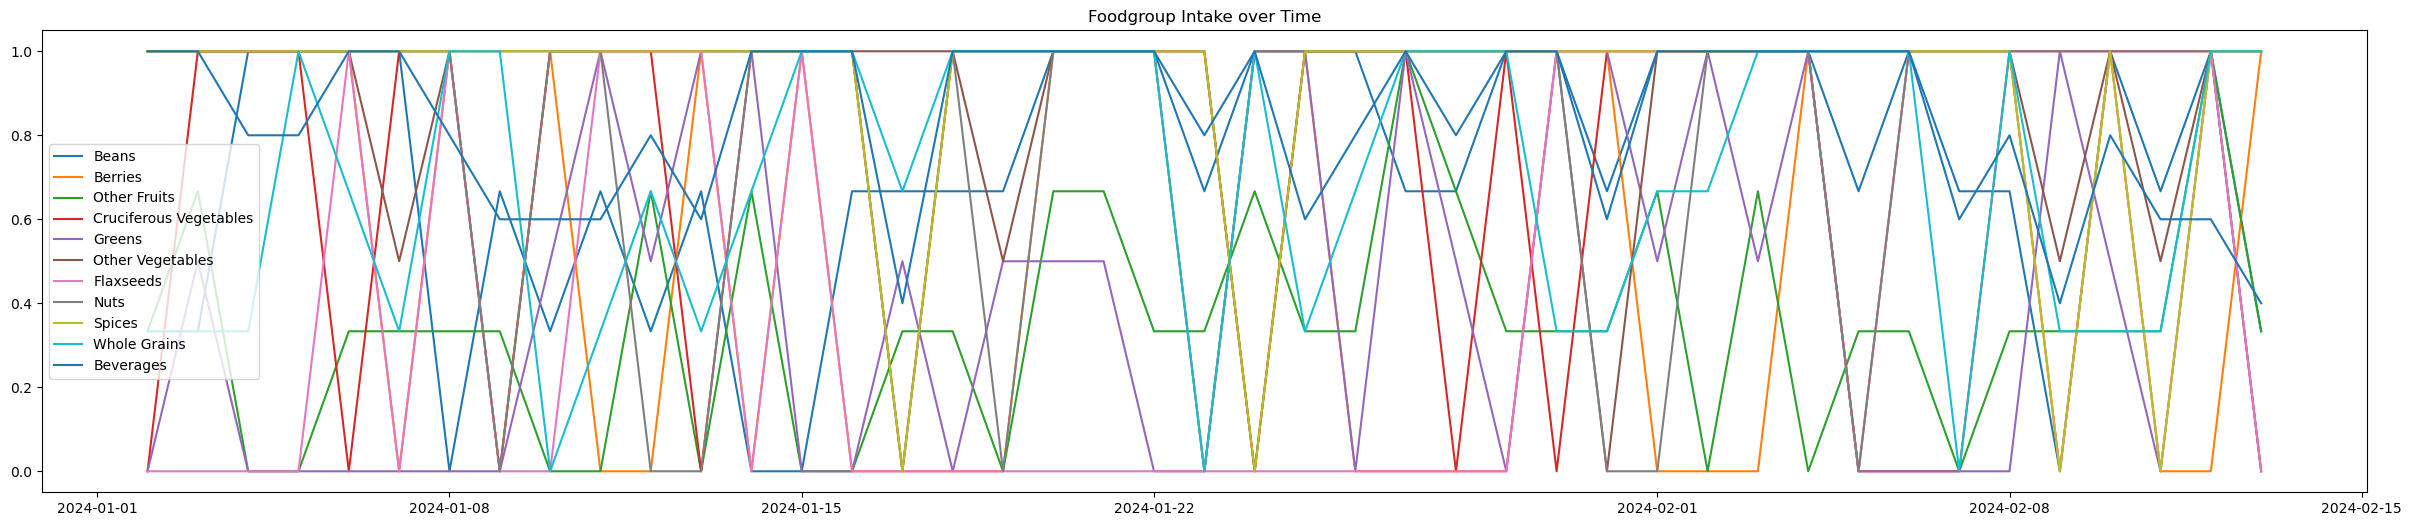

In [45]:
intake_over_time(dd_data, df_dd)

In [71]:
#the line plot did not really clarify anything just yet, given that there is currently a relatively small amount of data available. 
#for a better visual understanding of foodgroup intake over time : let's try a heatmap

import seaborn as sns
import matplotlib.pyplot as plt

def intake_over_time_heatmap(df_eaten, df_dd):
    # Create a copy of df_eaten to avoid modifying the original DataFrame
    df = df_eaten.copy()
    df = df.drop(columns=['Exercise', "day_of_week"])
    
    # Calculate the percentage-wise intake for each food group
    for col in df.columns[1:]:  
        servings_row = df_dd[df_dd['food_group'] == col]
        if not servings_row.empty:
            servings = servings_row.iloc[0]['servings']
            df[col] = df[col] / servings * 100
        else:
            # Handle the case where no matching row is found in df_dd
            print(f"No servings information found for food group '{col}'")
    
    # Set 'Date' column as the index
    df.set_index('Date', inplace=True)
    
    # Plot heatmap
    plt.figure(figsize=(30, 10))
    sns.heatmap(df.T, cmap='coolwarm', annot=True, fmt=".1f")
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Food Group')
    plt.title('Percentage-wise Intake of Different Food Groups Over Time')
    
    # Show the plot
    plt.show()


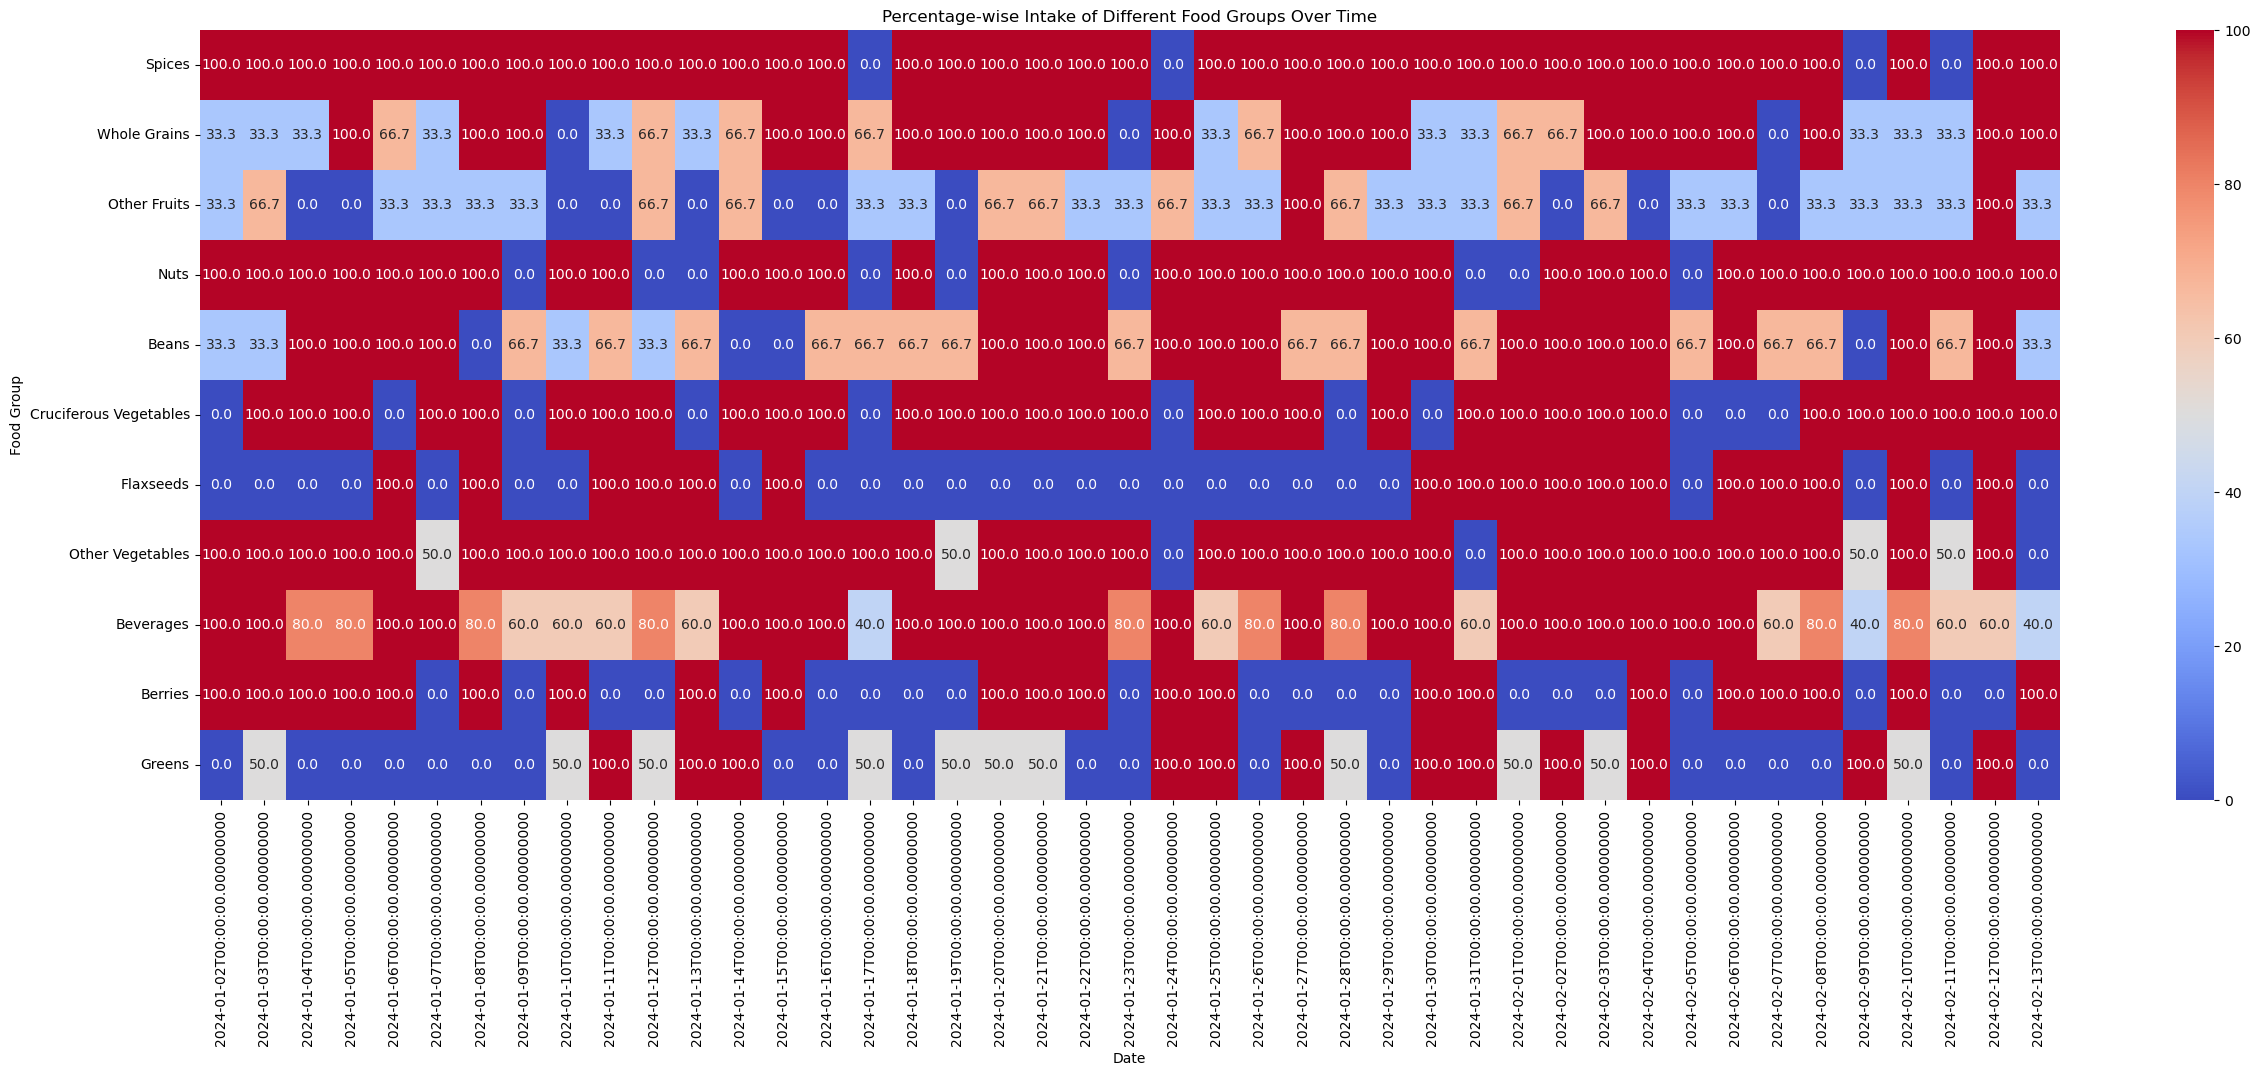

In [72]:
intake_over_time_heatmap(dd_data, df_dd)

In [23]:
#let's now have a closer look at individual foodgroups: percentage-wise, how does my intake of single foodgroups evolve overtime? 

def intake_over_time_single(df_eaten, df_dd, fg):
    plt.figure(figsize=(15, 6))
    plt.plot(df_eaten['Date'], (df_eaten[fg] / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]), label=fg)
    plt.title(f' {fg} Intake over Time')
    plt.legend()
    plt.show()

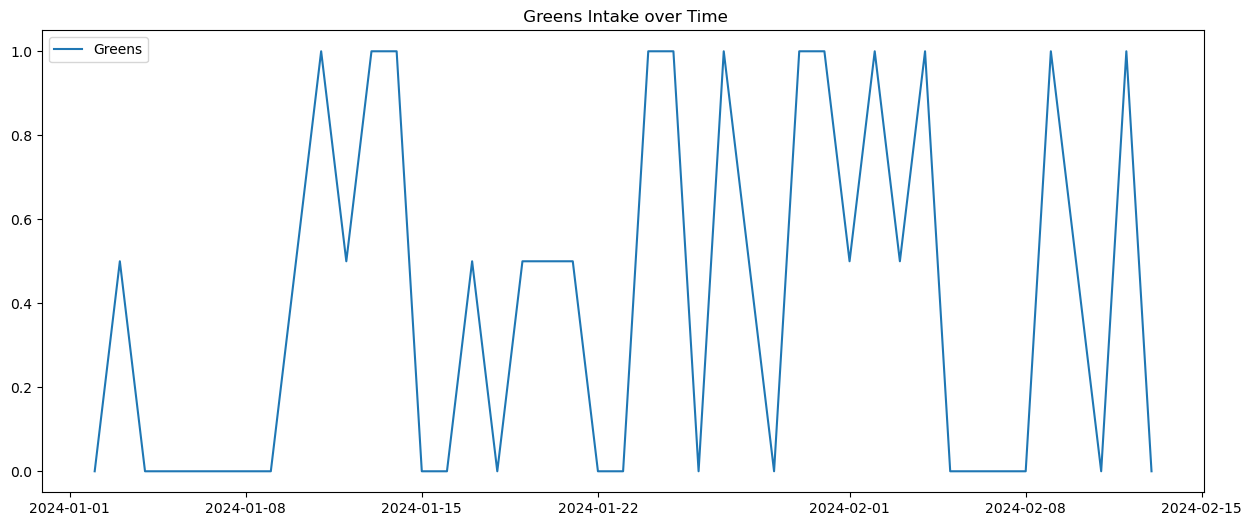

In [24]:
intake_over_time_single(dd_data, df_dd, "Greens")

In [43]:
#let's try and find out, whether day of the week has an influence on foodgroup intake 
#first, adding a column for day of week, based on the current "Date" column 
dd_data.head()
dd_data['day_of_week'] = dd_data['Date'].dt.day_name()

dd_data.groupby(dd_data["day_of_week"]).mean()

,Date,Spices,Whole Grains,Other Fruits,Nuts,Beans,Cruciferous Vegetables,Flaxseeds,Other Vegetables,Beverages,Berries,Exercise,Greens
day_of_week,,,,,,,,,,,,,
Friday,2024-01-22 12:00:00,0.833333,2.166667,0.666667,0.666667,2.000000,1.000000,0.333333,1.666667,4.000000,0.166667,0.666667,1.000000
Monday,2024-01-25 12:00:00,1.000000,3.000000,1.166667,0.833333,1.833333,0.833333,0.500000,2.000000,4.500000,0.500000,0.166667,0.333333
Saturday,2024-01-23 12:00:00,1.000000,2.166667,1.500000,0.833333,2.666667,0.666667,0.666667,2.000000,4.500000,0.666667,0.666667,1.166667
Sunday,2024-01-24 12:00:00,0.833333,2.166667,1.333333,1.000000,2.166667,0.833333,0.166667,1.666667,4.500000,0.333333,0.333333,1.000000
Thursday,2024-01-21 12:00:00,1.000000,1.833333,0.833333,0.833333,2.500000,1.000000,0.500000,2.000000,4.000000,0.500000,0.333333,0.833333
Tuesday,2024-01-23 00:00:00,1.000000,2.000000,0.857143,0.714286,2.000000,0.428571,0.285714,1.714286,4.142857,0.571429,0.142857,0.285714
Wednesday,2024-01-20 12:00:00,0.666667,1.166667,1.000000,0.666667,1.833333,0.500000,0.333333,1.333333,3.500000,0.833333,0.333333,1.166667


In [26]:
# plot the average intake per weekday of a single foodgroup of choice

def intake_per_day_single(df_eaten, df_dd, fg):
    
    #y should the percentage of intake reached
    #x_labels should be the days of the week
    plt.figure(figsize=(15, 6))

    x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    y = (df_eaten[fg].groupby(df_eaten["day_of_week"]).mean().reindex(x_labels)) / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]
    
    plt.bar(x_labels, y, color='skyblue')
    plt.title(f'{fg}: Weekly Intake')
    plt.ylim(0, 1)
    plt.show()

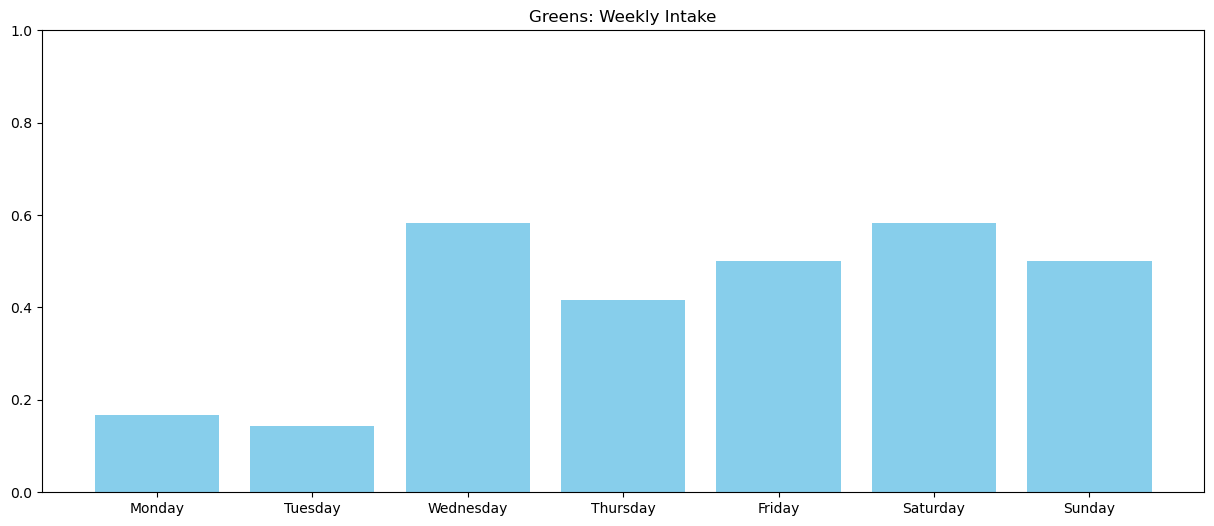

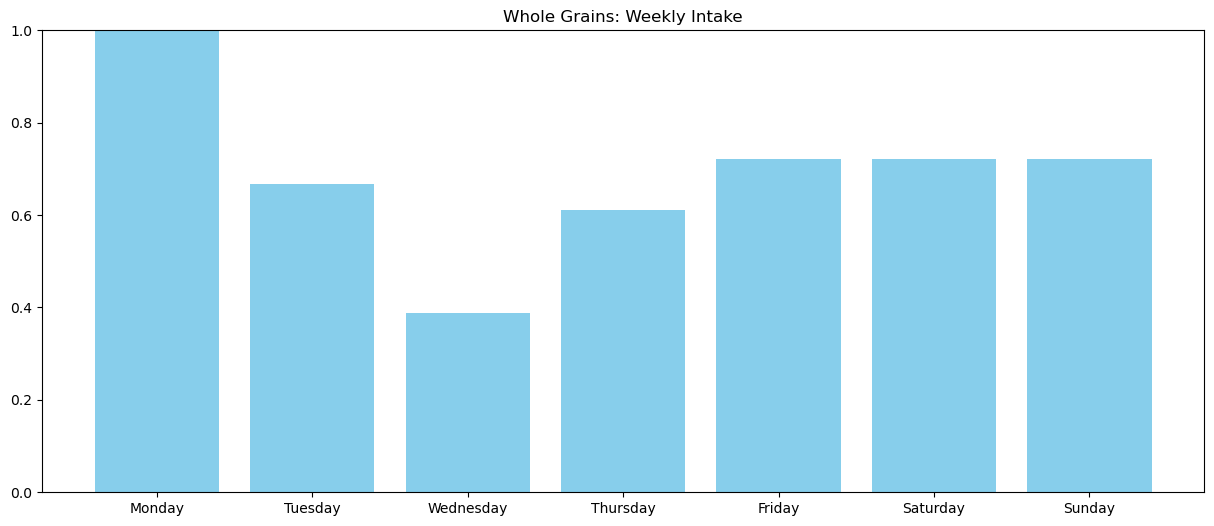

In [27]:
intake_per_day_single(dd_data, df_dd, "Greens")
intake_per_day_single(dd_data, df_dd, "Whole Grains")

In [73]:
#it might be interesting to compare two individual foodgroups to each other, e.g. Berries and Other Fruits


import matplotlib.pyplot as plt
import numpy as np

def compare_foodgroup_intake(df_eaten, df_dd, fg1, fg2):
    plt.figure(figsize=(20, 6))
    
    # Define the order of days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Calculate the width of each bar
    bar_width = 0.4
    
    # Calculate the x-coordinates for the bars of each food group
    x_values_fg1 = np.arange(len(day_order))
    x_values_fg2 = x_values_fg1 + bar_width
    
    # Calculate the percentage intake for the first food group
    percentage_intake_fg1 = (df_eaten[fg1].groupby(df_eaten["day_of_week"]).mean().reindex(day_order)) / df_dd.loc[df_dd['food_group'] == fg1, 'servings'].iloc[0]
    
    # Calculate the percentage intake for the second food group
    percentage_intake_fg2 = (df_eaten[fg2].groupby(df_eaten["day_of_week"]).mean().reindex(day_order)) / df_dd.loc[df_dd['food_group'] == fg2, 'servings'].iloc[0]
    # Plot the bars for the first food group
    plt.bar(x_values_fg1, percentage_intake_fg1.values, width=bar_width, label=fg1)
    
    # Plot the bars for the second food group
    plt.bar(x_values_fg2, percentage_intake_fg2.values, width=bar_width, label=fg2)
    
    # Adding labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Percentage of Intake Reached')
    plt.title('Weekly Intake Comparison for Food Groups')
    
    # Set x-ticks to the middle of each group
    plt.xticks(np.arange(len(day_order)) + 0.5 * bar_width, day_order)
    
    # Set y-axis limits
    plt.ylim(0, 1)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()


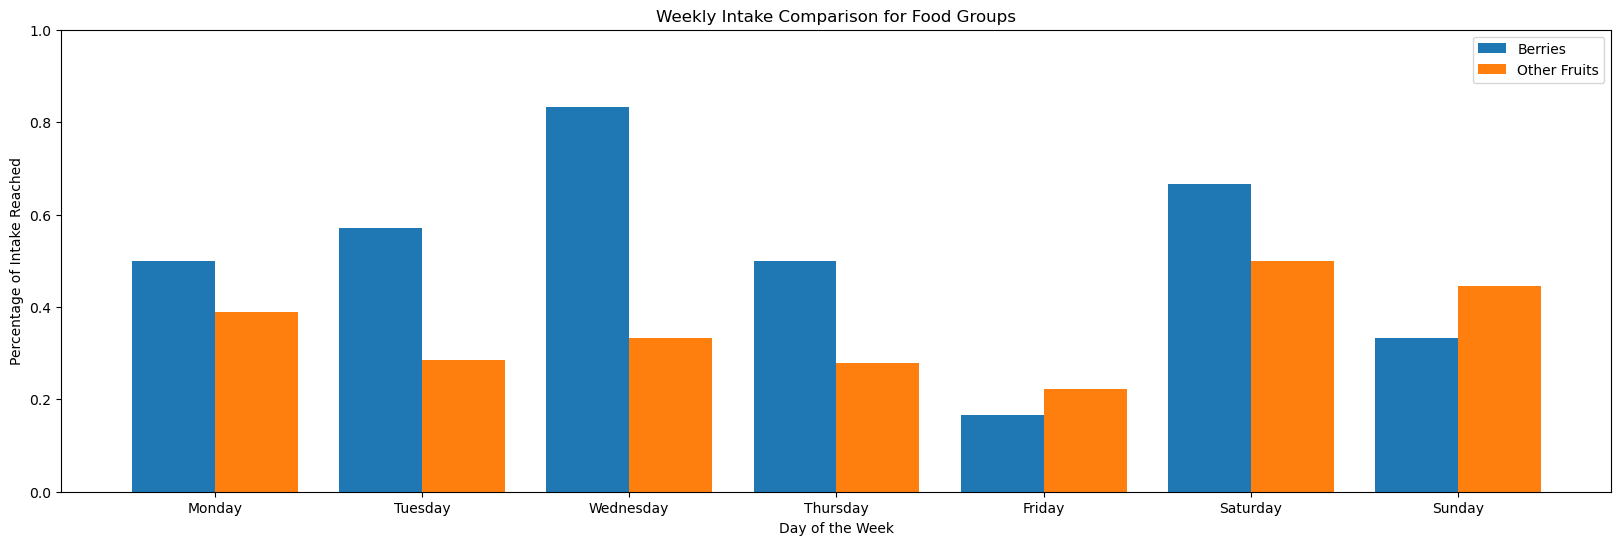

In [38]:
compare_foodgroup_intake(dd_data, df_dd, "Berries", "Other Fruits")